# Tune parameters for Gardiner Expy flow only models

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
plot_label="Speed (km/h)"

# Load and prepare data

In [10]:
df = pd.read_csv("./data/gardiner_flow.csv.zip")
df.head(3)

,collectedAt,month,day,day_of_week,hour,minute,currentSpeed
0,2022-07-14 12:45:00+00:00,July,14,Thursday,12,45,94
1,2022-07-14 12:51:44+00:00,July,14,Thursday,12,51,94
2,2022-07-14 12:55:27+00:00,July,14,Thursday,12,55,75


In [11]:
df.drop(["collectedAt"],axis=1,inplace=True)
df.head(3)

,month,day,day_of_week,hour,minute,currentSpeed
0,July,14,Thursday,12,45,94
1,July,14,Thursday,12,51,94
2,July,14,Thursday,12,55,75


In [12]:
categorical_feats = ["month","day_of_week"]

transformed_df = pd.get_dummies(df, columns=categorical_feats)
transformed_df = transformed_df.astype("float32")
transformed_df.head(3)

,day,hour,minute,currentSpeed,month_August,month_December,month_February,month_January,month_July,month_March,month_November,month_October,month_September,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,14.0,12.0,45.0,94.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14.0,12.0,51.0,94.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.0,12.0,55.0,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
X = transformed_df.drop("currentSpeed",axis=1)
y = transformed_df["currentSpeed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

## Sample 50% of remaining training data to run CV.
- The idea is have enough data that is representative of the dataset, while speeding up the CV performed by GridSearchCV.

In [14]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [15]:
metrics_df = pd.read_csv("./metrics/002_initial_metrics.csv.zip")
metrics_df.sort_values("r2",ascending=False)

,model,r2,mae,mse,rmse,mape,time_to_fit,time_to_predict
0,Random Forest,0.913182,1.727339,14.203959,3.768814,0.023677,6.775036,0.203156
1,Decision Tree,0.855916,1.732576,23.573060,4.855210,0.024202,0.107992,0.003676
2,XGBoost,0.846061,2.907144,25.484495,5.048217,0.039467,0.352739,0.018919
3,MLP,0.673072,4.827399,54.122640,7.356809,0.065896,40.545323,0.015713
4,Linear Regression,0.326866,7.946688,110.129074,10.494240,0.107932,0.021839,0.003812
5,Lasso,0.292887,8.025448,115.688310,10.755850,0.110912,0.014949,0.002579
6,Elastic Net,0.266358,8.351267,120.028610,10.955757,0.116191,0.014368,0.002530
7,Logistic Regression,-0.276799,6.965119,208.892500,14.453114,0.115319,8.341026,0.008929


- Based on R2 score (the closer to 1, the closer to reality it is)
    - Choosing XGBoost, Decision Tree, Random Forest, MLP

# Begin ML tasks

## XGBoost

In [ ]:
import xgboost as xgb

file_name = "003_xgboost"
model_name = "XGBoost"

param_grid = {
    "random_state": [42],
    "objective": ["reg:squarederror"],
    "tree_method": ["hist"],
    "predictor": ["cpu_predictor"],
    "num_parallel_tree": [10],
    "max_depth": [6, 8, 16],
    "n_estimators": [100, 250, 350],
    "max_leaves": [20, 40, 80],
    "alpha": [0.01, 0.1, 1],
    "learning_rate": [0.3, 0.5, 0.9],
    "n_jobs": [12]
}

estimator = xgb.XGBRegressor()

best_params = ml_help.run_param_search(estimator, param_grid, file_name, model_name, X_train_sample, y_train_sample, verbose=1)
best_params.drop(["score", "model"],axis=1,inplace=True)

params = ml_help.params_to_dict(file_name)
    
model_train, model_metrics_train = ml_help.train_and_test(file_name, model_name, xgb.XGBRegressor(**params), X_train, X_val, y_train, y_val, plot_label, dump_model=True, show_plot=True)
del model_train

Testing 243 param combinations for XGBoost. CV=5. Total fits: 1215

Searching space...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

file_name = "003_decision_tree"
model_name = "Decision Tree"

param_grid = {
    "random_state": [42],
    "criterion": ["squared_error"],
    "splitter": ["best"],
    "max_depth": [6,8,16,32,64,128],
    "min_samples_split": [2,4,8,16,32],
    "min_samples_leaf": [1,5,10,15,30],
    "max_leaf_nodes": [10,30,50,75,100],
    "n_jobs": [12]
}

estimator = DecisionTreeRegressor()

best_params = ml_help.run_param_search(estimator, param_grid, file_name, model_name, X_train_sample, y_train_sample, verbose=1)
best_params.drop(["score", "model"],axis=1,inplace=True)

params = ml_help.params_to_dict(file_name)

model_train, model_metrics_train = ml_help.train_and_test(file_name, model_name, DecisionTreeRegressor(**params), X_train, X_val, y_train, y_val, plot_label, dump_model=True, show_plot=True)
del model_train

## Random Forest

Testing 243 param combinations for Random Forest. CV=5. Total fits: 1215

Searching space...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Searching space... OK! Took 371.94692397117615 seconds
Storing best params...
Storing best params... OK
Fitting model...
Fitting model... OK! Took 1.0012431144714355 seconds

model Random Forest
r2 0.674519159421214
mae 4.313455993721178
mse 53.25076377542845
rmse 7.297312092505599
mape 0.060338008969185376
time_to_fit 1.0012431144714355
time_to_predict 0.03812146186828613

Dumping model...
Dumping model... OK! Took 0.5290219783782959 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


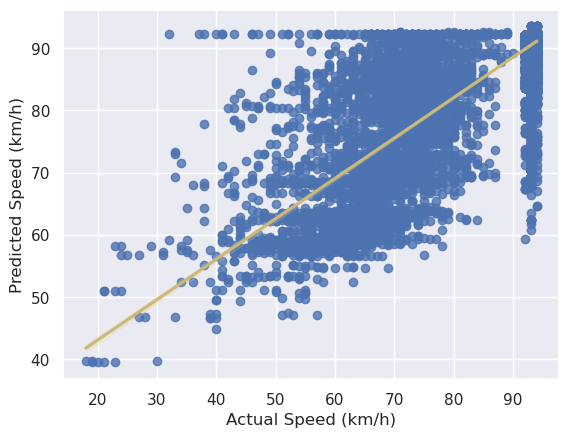

In [17]:
from sklearn.ensemble import RandomForestRegressor

file_name = "003_random_forest"
model_name = "Random Forest"

param_grid = {
    "n_estimators": [100,200,300],
    "max_depth": [16,32,48],
    "max_leaf_nodes": [10,50,100],
    "min_samples_leaf": [1,5,10],
    "min_samples_split": [2,8,16],
    "n_jobs": [12]
}

estimator = RandomForestRegressor()

best_params = ml_help.run_param_search(estimator, param_grid, file_name, model_name, X_train_sample, y_train_sample, verbose=1)
best_params.drop(["score", "model"],axis=1,inplace=True)

params = ml_help.params_to_dict(file_name)
    
model_train, model_metrics_train = ml_help.train_and_test(file_name, model_name, RandomForestRegressor(**params), X_train, X_val, y_train, y_val, plot_label, dump_model=True, show_plot=True)
del model_train

## Multi-layer Perceptron

In [ ]:
from sklearn.neural_network import MLPRegressor

file_name = "003_mlpr"
model_name = "MLP"

param_grid = {
    "random_state": [42],
    "hidden_layer_sizes": [(100), (100,50), (100,50,25)],
    "alpha": [0.0001, 0.001, 0.1],
    "learning_rate_init": [0.001, 0.1],
    "max_iter": [200, 300, 500],
    "tol": [1e-4],
    "epsilon": [1e-8, 1e-4],
    "n_iter_no_change": [3, 10],
    "n_jobs": [12]
}

estimator = MLPRegressor()

best_params = ml_help.run_param_search(estimator, param_grid, file_name, model_name, X_train_sample, y_train_sample, verbose=1)
best_params.drop(["score", "model"],axis=1,inplace=True)

params = ml_help.params_to_dict(file_name)

model_train, model_metrics_train = ml_help.train_and_test(file_name, model_name, MLPRegressor(**params), X_train, X_val, y_train, y_val, plot_label, dump_model=True, show_plot=True)
del model_train